## Lab08 - PCA
Name: Anh Kieu  
Class: CSCI 349 - Intro to Data Mining  
Semester: Spring 2021  
Instructor: Brian King  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
import sklearn.preprocessing
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA

#### 1) [P] Set up pandas data

In [2]:
df = pd.DataFrame(data = {'test1' : ['A', 'C', 'C', 'B', 'A', 'B', 'C', 'B'], 'test2' : ['excellent', 'fair', 'good', 'fair', 'poor', 'excellent', 'good', 'good'], 'test3' : [25, 32, 60, 53, 23, 37, 45, 49]})
df['test1'] = pd.Categorical(df['test1'])
df['test2'] = pd.Categorical(df['test2'], ordered = True, categories = ['poor', 'fair', 'good', 'excellent'])
df['test3'] = pd.to_numeric(df['test3'], downcast = 'unsigned')
new_index = ['A' + str(x) for x in range(df.shape[0])]
df.index = (new_index)

In [3]:
df

,test1,test2,test3
A0,A,excellent,25
A1,C,fair,32
A2,C,good,60
A3,B,fair,53
A4,A,poor,23
A5,B,excellent,37
A6,C,good,45
A7,B,good,49


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, A0 to A7
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   test1   8 non-null      category
 1   test2   8 non-null      category
 2   test3   8 non-null      uint8   
dtypes: category(2), uint8(1)
memory usage: 424.0+ bytes


#### 2) [PM] Show the output of df.describe(include='all'). What does the include='all' parameter do?

In [5]:
df.describe(include = 'all')

,test1,test2,test3
count,8,8,8.000000
unique,3,4,NaN
top,B,good,NaN
freq,3,3,NaN
mean,NaN,NaN,40.500000
std,NaN,NaN,13.416408
min,NaN,NaN,23.000000
25%,NaN,NaN,30.250000
50%,NaN,NaN,41.000000
75%,NaN,NaN,50.000000


include = 'all' displays more information about the dataframe as it also displays statistics describing categorical columns. 

#### 3) [PM] Show the output of df.test1.cat.categories, and df.test2.cat.categories. What is this showing? Does it work for df.test3.cat.categories? (If not, then comment this line out.)

In [6]:
print(df.test1.cat.categories)
print(df.test2.cat.categories)
# print(df.test3.cat.categories)

Index(['A', 'B', 'C'], dtype='object')
Index(['poor', 'fair', 'good', 'excellent'], dtype='object')


This prints out the categories in the columns. Line 3 does not work because it is a numerical data.

#### 4) [PM] Show the output of df.test1.cat.codes, and df.test2.cat.codes. What is this showing?

In [7]:
print(df.test1.cat.codes)
print(df.test2.cat.codes)

A0    0
A1    2
A2    2
A3    1
A4    0
A5    1
A6    2
A7    1
dtype: int8
A0    3
A1    1
A2    2
A3    1
A4    0
A5    3
A6    2
A7    2
dtype: int8


This is showing the underlying index for each category in each variable.

#### 5) [P] Report the counts of each level of the categorical variables.

In [8]:
df['test1'].value_counts()

B    3
C    3
A    2
Name: test1, dtype: int64

In [9]:
df['test2'].value_counts()

good         3
fair         2
excellent    2
poor         1
Name: test2, dtype: int64

#### 6) [P] Report a cross tabulation (i.e. contingency table) between test1 and test2. Include the margins (i.e. the sum of the rows and the columns) in your reported table (HINT: Look up pandas crosstab() function)

In [10]:
pd.crosstab(df['test1'], df['test2'], margins = True)

test2,poor,fair,good,excellent,All
test1,,,,,
A,1,0,0,1,2
B,0,1,1,1,3
C,0,1,2,0,3
All,1,2,3,2,8


#### 7) [P] From the previous table, store the contingency table without the margins in a variable called observed

In [11]:
observed = pd.crosstab(df['test1'], df['test2'], margins = True).iloc[:-1, :-1]

In [12]:
observed

test2,poor,fair,good,excellent
test1,,,,
A,1,0,0,1
B,0,1,1,1
C,0,1,2,0


#### 8) [P] Run a chi-squared test to determine whether test1 and test2 are dependent.

In [13]:
stats.chi2_contingency(observed, correction = False)

(6.444444444444444,
 0.37528525266160834,
 6,
 array([[0.25 , 0.5  , 0.75 , 0.5  ],
        [0.375, 0.75 , 1.125, 0.75 ],
        [0.375, 0.75 , 1.125, 0.75 ]]))

Thus, since our p value is 0.375, which is bigger than our threshold p = 0.05

#### 9) [P] Create a new data frame called df_num, that represents a numeric version of the above. Do NOT do any rescaling of your variables yet!

In [14]:
df_num = pd.DataFrame({'test1':df['test1'].cat.codes, 'test2': df['test2'].cat.codes, 'test3': df['test3']})

In [15]:
df_num

,test1,test2,test3
A0,0,3,25
A1,2,1,32
A2,2,2,60
A3,1,1,53
A4,0,0,23
A5,1,3,37
A6,2,2,45
A7,1,2,49


#### 10) [P] As you learned in lecture, you must rescale your data to fall on a similar scale. 
There are different approaches to doing so. A standardized z-score is among the most common, but not necessarily always the
best approach, especially when you are dealing with numeric representations of true categorical data.
Rescaling your data to all fall between 0 and 1 is also a common approach, particularly when you have
categorical data.
Let's first try to rescale our data to all fall between the values of 0 and 1. Use the MinMaxScaler in
sklearn.preprocessing to rescale all variables to fall between 0 and 1. Store the transformed data as a
pandas data frame called df_num_zeroone,.

In [16]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(df_num)

MinMaxScaler()

In [17]:
df_num_zeroone = pd.DataFrame(scaler.transform(df_num), columns = ['test1', 'test2', 'test3'], index = new_index)

In [18]:
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.054054
A1,1.0,0.333333,0.243243
A2,1.0,0.666667,1.000000
A3,0.5,0.333333,0.810811
A4,0.0,0.000000,0.000000
A5,0.5,1.000000,0.378378
A6,1.0,0.666667,0.594595
A7,0.5,0.666667,0.702703


#### 11) [P] Notice the value of test3. Quite often, when we have solid knowledge of what we expect our range to be, then we can rescale our data using that knowledge. 
In the case of test3, you learned that the data must
fall between 0 and 100. Therefore, reassign test3 so that the min and max before rescaling are assuming to
be between 0 and 100, respectively. (i.e. simply divide the original variable by 100)

In [19]:
df_num_zeroone['test3'] = df_num['test3']/100

In [20]:
df_num_zeroone

,test1,test2,test3
A0,0.0,1.000000,0.25
A1,1.0,0.333333,0.32
A2,1.0,0.666667,0.60
A3,0.5,0.333333,0.53
A4,0.0,0.000000,0.23
A5,0.5,1.000000,0.37
A6,1.0,0.666667,0.45
A7,0.5,0.666667,0.49


#### 12) [P] Compute a single distance matrix called distmat_zeroone.

In [21]:
distmat_zeroone = pairwise_distances(df_num_zeroone, metric = 'euclidean')

In [22]:
distmat_zeroone = pd.DataFrame(np.round(distmat_zeroone, 3), columns = new_index, index = new_index)

In [23]:
distmat_zeroone

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000,1.204,1.111,0.879,1.000,0.514,1.073,0.647
A1,1.204,0.000,0.435,0.542,1.058,0.835,0.358,0.625
A2,1.111,0.435,0.000,0.605,1.258,0.643,0.150,0.512
A3,0.879,0.542,0.605,0.000,0.672,0.686,0.606,0.336
A4,1.000,1.058,1.258,0.672,0.000,1.127,1.222,0.873
A5,0.514,0.835,0.643,0.686,1.127,0.000,0.606,0.354
A6,1.073,0.358,0.150,0.606,1.222,0.606,0.000,0.502
A7,0.647,0.625,0.512,0.336,0.873,0.354,0.502,0.000


#### 13) [P] Output the top three closest pairs of observations.

In [24]:
def print_obs(i, ind, dist, t):
    '''
    i: index in for loop
    ind: tuple of ind lower triangle matrix, ind[0] > ind[1]
    t : type, either closest or farthest
    '''
    p1 = new_index[ind[0]]
    p2 = new_index[ind[1]]
    print(f"{t}: #{i}: [{p1}, {p2}], dist = {dist: .3f}")
    print(df.loc[[p1, p2]])

In [25]:
from scipy.spatial.distance import pdist
dist_arr = pdist(df_num_zeroone)
tup_index = np.triu_indices(df.shape[0], k = 1)
for i in range(3):
    min_ind = dist_arr.argmin()
    print(min_ind)
    print_obs(i, (tup_index[0][min_ind], tup_index[1][min_ind]), dist_arr[min_ind], 'Closest')
    dist_arr[min_ind] = float("inf")
    print()

16
Closest: #0: [A2, A6], dist =  0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45

21
Closest: #1: [A3, A7], dist =  0.336
   test1 test2  test3
A3     B  fair     53
A7     B  good     49

26
Closest: #2: [A5, A7], dist =  0.354
   test1      test2  test3
A5     B  excellent     37
A7     B       good     49



#### 14) [P] Now, output the three most distant (least similar) pairs of observations.

In [26]:
dist_arr = pdist(df_num_zeroone)
for i in range(3):
    max_ind = dist_arr.argmax()
    print_obs(i, (tup_index[0][max_ind], tup_index[1][max_ind]), dist_arr[max_ind], 'Most distant')
    dist_arr[max_ind] = -float("inf")
    print()

Most distant: #0: [A2, A4], dist =  1.258
   test1 test2  test3
A2     C  good     60
A4     A  poor     23

Most distant: #1: [A4, A6], dist =  1.222
   test1 test2  test3
A4     A  poor     23
A6     C  good     45

Most distant: #2: [A0, A1], dist =  1.204
   test1      test2  test3
A0     A  excellent     25
A1     C       fair     32



#### 15) [P] Create a new data frame, df_num_binarized, that stores the a binarized version for test1 and test2.

In [27]:
encoder = sklearn.preprocessing.OneHotEncoder(sparse = False, dtype = int)
encoder.fit(df.loc[:, ['test1', 'test2']])
df_num_binarized = pd.DataFrame(encoder.transform(df[['test1', 'test2']]), index = new_index, columns = encoder.get_feature_names(['test1', 'test2']))
df_num_binarized['test3'] = df_num_zeroone['test3']

In [28]:
df_num_binarized

,test1_A,test1_B,test1_C,test2_excellent,test2_fair,test2_good,test2_poor,test3
A0,1,0,0,1,0,0,0,0.25
A1,0,0,1,0,1,0,0,0.32
A2,0,0,1,0,0,1,0,0.60
A3,0,1,0,0,1,0,0,0.53
A4,1,0,0,0,0,0,1,0.23
A5,0,1,0,1,0,0,0,0.37
A6,0,0,1,0,0,1,0,0.45
A7,0,1,0,0,0,1,0,0.49


#### 16) [P] Now, compute distmat_binarized by computing the distance matrix for the df_binarized.

In [29]:
distmat_binarized = pairwise_distances(df_num_binarized, metric = 'euclidean')
pd.DataFrame(np.round(distmat_binarized, 3), columns = new_index, index = new_index)

,A0,A1,A2,A3,A4,A5,A6,A7
A0,0.000,2.001,2.030,2.020,1.414,1.419,2.010,2.014
A1,2.001,0.000,1.442,1.430,2.002,2.001,1.420,2.007
A2,2.030,1.442,0.000,2.001,2.034,2.013,0.150,1.418
A3,2.020,1.430,2.001,0.000,2.022,1.423,2.002,1.415
A4,1.414,2.002,2.034,2.022,0.000,2.005,2.012,2.017
A5,1.419,2.001,2.013,1.423,2.005,0.000,2.002,1.419
A6,2.010,1.420,0.150,2.002,2.012,2.002,0.000,1.415
A7,2.014,2.007,1.418,1.415,2.017,1.419,1.415,0.000


#### 17) [P] Report the three closest pairs, and the three most distant pairs from distmat_binarized

In [30]:
dist_arr_bin = pdist(df_num_binarized)
tup_index = np.triu_indices(df.shape[0], k = 1)
for i in range(3):
    min_ind = dist_arr_bin.argmin()
    print_obs(i, (tup_index[0][min_ind], tup_index[1][min_ind]), dist_arr_bin[min_ind], 'Closest')
    dist_arr_bin[min_ind] = float("inf")
    print()

Closest: #0: [A2, A6], dist =  0.150
   test1 test2  test3
A2     C  good     60
A6     C  good     45

Closest: #1: [A0, A4], dist =  1.414
   test1      test2  test3
A0     A  excellent     25
A4     A       poor     23

Closest: #2: [A3, A7], dist =  1.415
   test1 test2  test3
A3     B  fair     53
A7     B  good     49



In [31]:
dist_arr_bin = pdist(df_num_binarized)
for i in range(3):
    max_ind = dist_arr_bin.argmax()
    print_obs(i, (tup_index[0][max_ind], tup_index[1][max_ind]), dist_arr_bin[max_ind], 'Most distant')
    dist_arr_bin[max_ind] = -float("inf")
    print()

Most distant: #0: [A2, A4], dist =  2.034
   test1 test2  test3
A2     C  good     60
A4     A  poor     23

Most distant: #1: [A0, A2], dist =  2.030
   test1      test2  test3
A0     A  excellent     25
A2     C       good     60

Most distant: #2: [A3, A4], dist =  2.022
   test1 test2  test3
A3     B  fair     53
A4     A  poor     23



#### 18) [M] Take a moment and compare and contrast your results. 
Which method do you think have the better
results? Why? Which variable do you think was the distinguishing player in affecting the different outcomes
between both of the above approaches to transforming your data to numeric results? Why? Summarize what
would have been the best transformation to make for all three variables that would have given the most
accurate results.

I personally think the first method is better as the 'test2' variable is ordinal and has more categories and thus should be given more attention between the two (test1 and test2).  
However, I think both methods kind of hand-wavy in the sense that we should use binarization for test1 and minmax for test2 as test1 is categorical nominal (no level, thus, there should not be different distances among categories), and test2 is categorical ordinal and thus should have distances among the categories. That would be the best transformation that gives the most accurate results.

#### 19) [P] Load in your next dataset using the following:

In [32]:
df_car_crashes = sns.load_dataset('car_crashes')

#### 20) [P] Preprocess your data.

In [33]:
df_car_crashes.set_index(df_car_crashes['abbrev'], drop = True, inplace = True)
df_car_crashes = df_car_crashes.rename_axis('state')

In [34]:
df_car_crashes = df_car_crashes.drop('abbrev', axis = 1)
df_car_crashes.head(5)

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
state,,,,,,,
AL,18.8,7.332,5.640,18.048,15.040,784.55,145.08
AK,18.1,7.421,4.525,16.290,17.014,1053.48,133.93
AZ,18.6,6.510,5.208,15.624,17.856,899.47,110.35
AR,22.4,4.032,5.824,21.056,21.280,827.34,142.39
CA,12.0,4.200,3.360,10.920,10.680,878.41,165.63


#### 21) [P] Create a new dataframe called df_car_crashes_zscore that represents the zscore transformation for df_car_crashes. Again, show the first five rows.

In [35]:
df_car_crashes_zscore = df_car_crashes.apply(zscore)
df_car_crashes_zscore.head(5)

,total,speeding,alcohol,not_distracted,no_previous,ins_premium,ins_losses
state,,,,,,,
AL,0.737446,1.168148,0.439938,1.002301,0.277692,-0.580083,0.430514
AK,0.565936,1.212695,-0.211311,0.608532,0.807258,0.943258,-0.022900
AZ,0.688443,0.756709,0.187615,0.459357,1.033141,0.070876,-0.981778
AR,1.619498,-0.483614,0.547408,1.676052,1.951700,-0.337701,0.321125
CA,-0.928653,-0.399524,-0.891763,-0.594276,-0.891968,-0.048418,1.266178


#### 22) [P] Create a distance matrix called distmat_cars based on the df_car_crashes_zscore.

In [36]:
distmat_cars = pairwise_distances(df_car_crashes_zscore, metric = 'euclidean')
distmat_cars = pd.DataFrame(np.round(distmat_cars, 3), columns = df_car_crashes.index, index = df_car_crashes.index)
distmat_cars

state,AL,AK,AZ,AR,CA,CO,CT,DE,DC,FL,...,SD,TN,TX,UT,VT,VA,WA,WV,WI,WY
state,,,,,,,,,,,,,,,,,,,,,
AL,0.000,1.849,1.876,2.616,3.450,2.687,4.023,2.427,6.627,2.863,...,2.273,1.760,1.768,4.074,2.984,3.691,4.099,2.659,3.882,1.346
AK,1.849,0.000,1.461,2.962,3.504,2.675,3.720,1.305,5.923,2.014,...,3.031,2.613,1.983,3.820,3.231,3.940,3.874,2.760,4.080,1.794
AZ,1.876,1.461,0.000,2.593,3.873,2.691,4.341,2.323,6.312,2.472,...,1.806,2.414,2.496,3.639,2.565,3.911,3.717,3.095,3.452,1.165
AR,2.616,2.962,2.593,0.000,4.774,4.082,5.512,3.376,7.648,2.723,...,2.756,2.090,2.858,5.376,4.013,4.578,5.501,2.401,5.215,3.105
CA,3.450,3.504,3.873,4.774,0.000,1.382,1.360,2.801,3.725,3.294,...,4.730,2.985,4.199,2.525,2.638,1.212,2.322,5.589,3.094,3.393
CO,2.687,2.675,2.691,4.082,1.382,0.000,2.171,2.349,4.294,2.885,...,3.599,2.450,3.624,1.893,1.580,1.580,1.825,4.943,2.114,2.217
CT,4.023,3.720,4.341,5.512,1.360,2.171,0.000,2.793,3.101,3.490,...,5.401,3.817,4.346,3.070,3.461,2.372,2.500,5.938,3.628,3.900
DE,2.427,1.305,2.323,3.376,2.801,2.349,2.793,0.000,5.107,1.443,...,3.828,2.557,2.171,3.771,3.324,3.389,3.571,3.438,4.038,2.427
DC,6.627,5.923,6.312,7.648,3.725,4.294,3.101,5.107,0.000,5.343,...,7.356,6.231,7.019,3.805,4.899,4.000,3.304,8.419,4.940,6.197


#### 23) [P] An interesting way to suggest outliers is to take a distance matrix, aggregate the mean over each row or column, then sort the output in order.

In [37]:
distmat_cars.mean().sort_values(ascending = False).head(10)

state
DC    5.265667
ND    5.257275
SC    5.214314
LA    4.767431
MT    4.759843
WV    4.512765
NJ    4.310804
MA    4.197490
MS    4.048392
AR    3.897667
dtype: float64

#### 24) [M] From this analysis, which 4 states seem to be strongest outliers?

Strongest outliers: DC, ND, SC, LA

#### 25) [P] OK. Let's explore the data visually. 
First, using the original, unscaled data frame df_car_crashes,
create a scatter plot of insurance premiums vs. insurance losses, with total number of accidents as the size of
the point.

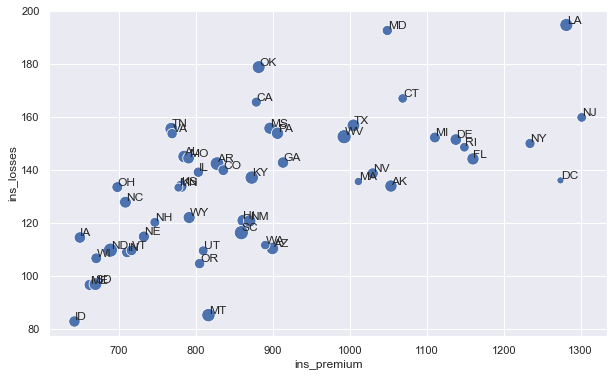

In [38]:
plt.figure(figsize = (10,6))
sns.set_theme()
sns.scatterplot(data = df_car_crashes, x = 'ins_premium', y = 'ins_losses', size = 'total', sizes = (50, 200), legend = False)
# ref: https://towardsdatascience.com/how-to-add-text-labels-to-scatterplot-in-matplotlib-seaborn-ec5df6afed7a
for i in range(df_car_crashes.shape[0]):
    plt.text(x = df_car_crashes.ins_premium[i] + 0.5, y = df_car_crashes.ins_losses[i] + 0.5, s = df_car_crashes.index[i])

#### 26) [P] Next, generate two interesting plots that show some relationships between variables in the data.

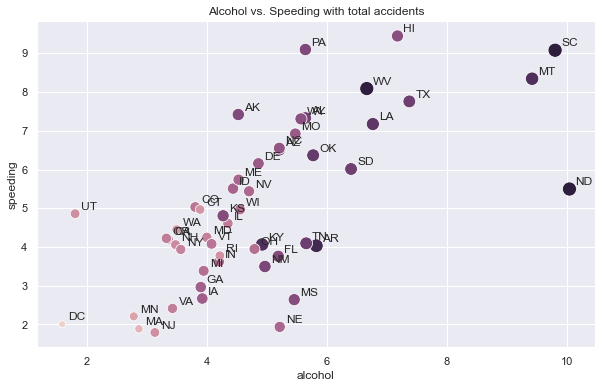

In [39]:
plt.figure(figsize = (10,6))
sns.set_theme()
ax = sns.scatterplot(data = df_car_crashes, x = 'alcohol', y = 'speeding', hue = 'total', size = 'total', sizes = (50, 200), legend = False)
# ref: https://towardsdatascience.com/how-to-add-text-labels-to-scatterplot-in-matplotlib-seaborn-ec5df6afed7a
for i in range(df_car_crashes.shape[0]):
    plt.text(x = df_car_crashes.alcohol[i] + 0.1, y = df_car_crashes.speeding[i] + 0.1, s = df_car_crashes.index[i])
ax.set_title("Alcohol vs. Speeding with total accidents")
plt.show()

- I use both color and size for total number of accident as it makes it clearer (extra but I think it is more obvious this way)  
Analysis: There is a linear correlation between the alcohol rate and the speeding rate, as evident in the graph: the more the alcohol rate, the more the speeding. There is also positive correlation between alcohol and the number of total accident.

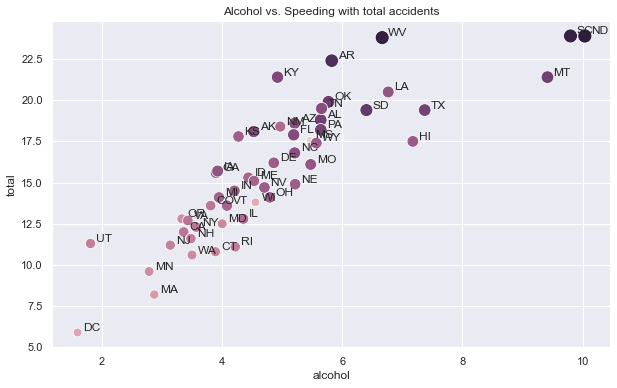

In [40]:
plt.figure(figsize = (10,6))
sns.set_theme()
ax = sns.scatterplot(data = df_car_crashes, x = 'alcohol', y = 'total', hue = 'not_distracted', size = 'not_distracted', sizes = (50, 200), legend = False)
# ref: https://towardsdatascience.com/how-to-add-text-labels-to-scatterplot-in-matplotlib-seaborn-ec5df6afed7a
for i in range(df_car_crashes.shape[0]):
    plt.text(x = df_car_crashes.alcohol[i] + 0.1, y = df_car_crashes.total[i] + 0.1, s = df_car_crashes.index[i])
ax.set_title("Alcohol vs. Speeding with total accidents")
plt.show()

- I use both color and size for not_distracted factor as it makes it clearer (extra but I think it is more obvious this way). I assume the higher the not_distracted, the more distracted the driver was in the accident (I can't find data online for this)  
Analysis: There is a linear correlation between the alcohol rate and the total number of accident, as evident in the graph: the more the alcohol rate, the more the total accident. There is also positive correlation between alcohol and distraction factor.

#### 27) [P] Run a full PCA on the z_score transformed data.
output the components, explained variance,
and the explained variance ratio.

In [41]:
pca = PCA(n_components = df_car_crashes.shape[1])
pca.fit(df_car_crashes_zscore)
print("Components:\n", pca.components_)
print("Exp. Var:\n", pca.explained_variance_)
print("Exp. Var. Ratio:\n", pca.explained_variance_ratio_)

Components:
 [[ 0.47947078  0.37534719  0.45437635  0.4380328   0.45703414 -0.1308319
  -0.06996048]
 [ 0.06893769  0.0765846   0.03345835  0.04237473  0.0961294   0.6852266
   0.71252436]
 [-0.26908802  0.81826935  0.08293253 -0.12616845 -0.31798812  0.25614247
  -0.26173503]
 [ 0.0389558  -0.36374887  0.14834351  0.1712655   0.03948141  0.65639617
  -0.61839859]
 [ 0.14597659 -0.02282818  0.35479821 -0.85646854  0.33611019  0.04214531
  -0.06327152]
 [-0.16970508 -0.22479246  0.7837677   0.08510479 -0.50401185 -0.11577348
   0.17805184]
 [ 0.80082487  0.01784783 -0.15285774 -0.14247844 -0.55875371  0.04126619
  -0.02804966]]
Exp. Var:
 [4.0942308  1.6095732  0.56161403 0.35753958 0.2863854  0.20263316
 0.02802383]
Exp. Var. Ratio:
 [0.57342168 0.22543042 0.07865743 0.05007557 0.04011    0.02837999
 0.00392491]


#### 28) [M] Use your intuition – what do the weights of the first couple of components suggest where most of the variance in the data is coming from?

Most variance of the data is coming from the first 5 components of this PCA basis

#### 29) [P] Create a plot of the cumulative sum of the explained variance. How many components will get you to 90% of the explained variance?

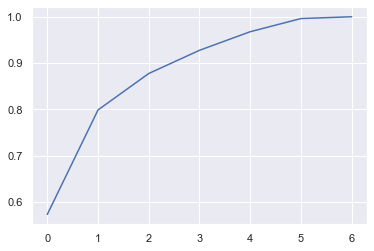

In [42]:
cum_sum = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(cum_sum)
plt.show()

Thus, with only 3 components, we already obtain 90% of the variance

#### 30) [P] Transform the z_score transformed data using your PCA model (i.e. using the transform function of the pca object.)

In [43]:
X = pca.transform(df_car_crashes_zscore)

#### 31) [P] Generate a 2D plot using the first two principal components as your x and y coordinates. Be sure to label each point, and label your axes as component 1 and component 2, respectively.

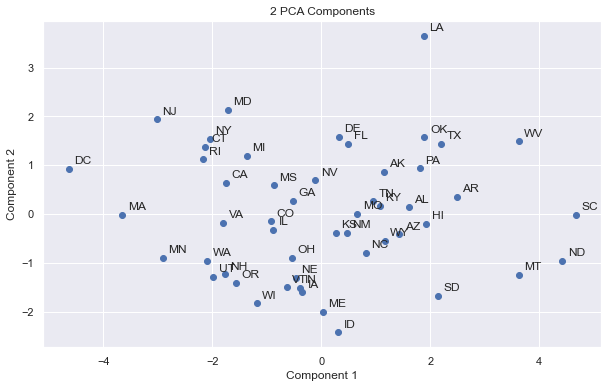

In [44]:
plt.figure(figsize = (10, 6))
ax = plt.scatter(X[:, 0], X[:, 1])
for i in range(df_car_crashes.shape[0]):
    plt.text(x = X[i, 0] + 0.1, y = X[i, 1] + 0.1, s = df_car_crashes.index[i])
plt.title("2 PCA Components")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

#### 32) [M] Compare the states you reported as potential outliers above to those that appear to be outliers from your plot. Do the same results seem to hold?

From this graph, the potential outliers seem to be LA, DC, SC, ND, WV, MT. The results seem to hold.

#### 33) [P] Read how to generate a 3D scatterplot in seaborn or plotly, and use it to generate a scatterplot of the first 3 components.

In [46]:
X_df = pd.DataFrame({'component1': X[:, 0], 'component2': X[:, 1], 'component3': X[:, 2]}, index = df_car_crashes.index)

In [56]:
import plotly.express as px
import plotly

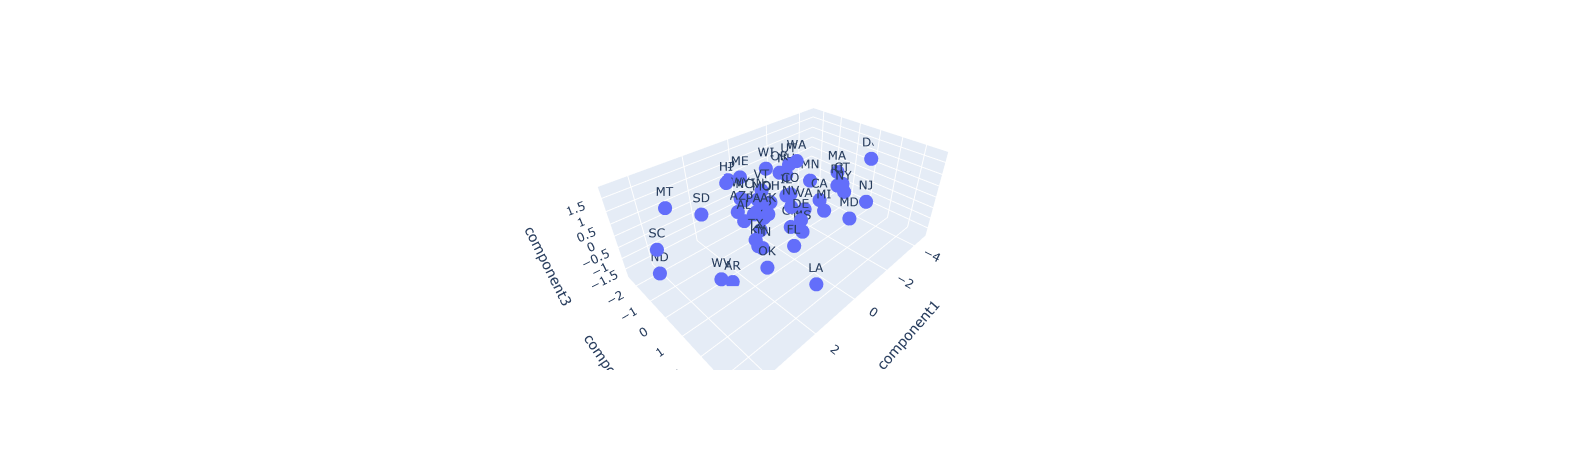

<Figure size 720x576 with 0 Axes>

In [58]:
plt.figure(figsize = (10,8))
fig = px.scatter_3d(X_df, x='component1', y = 'component2', z='component3', text = X_df.index)
fig.show()

#### 34) [M] Do the same outliers still stand out?

We can still see LA standing out, along with SC and ND, but DC does not stand out that much. But when we project it to just comp3 and comp1, DC does stand out.